<h2> <span style="color:blue;">Recommender System:- </span></h2>

In our previous notebook, we explored the concept of recommender systems, including various types and even built three of them. However, using the previous data to create a collaborative filtering system wasn't feasible. Therefore, in this notebook, we'll use "fastai" to download movie data and then we will build a collaborative recommender system. If you find this notebook helpful then feel free to use this code to build your own. Happy learning!!

<h3> <span style="color:green;">What is Collaborative Filtering</span></h3> 
Collaborative filtering is a technique used by recommender systems to predict a user's preferences or interests by gathering preferences or information from many users (collaborating). This technique assumes that if two users have similar preferences for some items, they are likely to have similar preferences for other items as well. <h4><b><span style="color:brown;">Example:</span></b></h4>
Let's say you have two friends, Ratna and Dipesh, who share similar movie preferences. Ratna tells you she enjoyed a movie called "OMG2," and you know Dipesh hasn't watched it. So, you suggest the movie to Dipesh because there's a good chance he will also enjoy it. Collaborative filtering applies this idea to a larger scale, known as "Group Wisdom," where it looks at what many users like and dislike, finding patterns among their preferences. Then, when you're seeking something new to watch or listen to, collaborative filtering recommends things based on what people with similar tastes have enjoyed in the past.

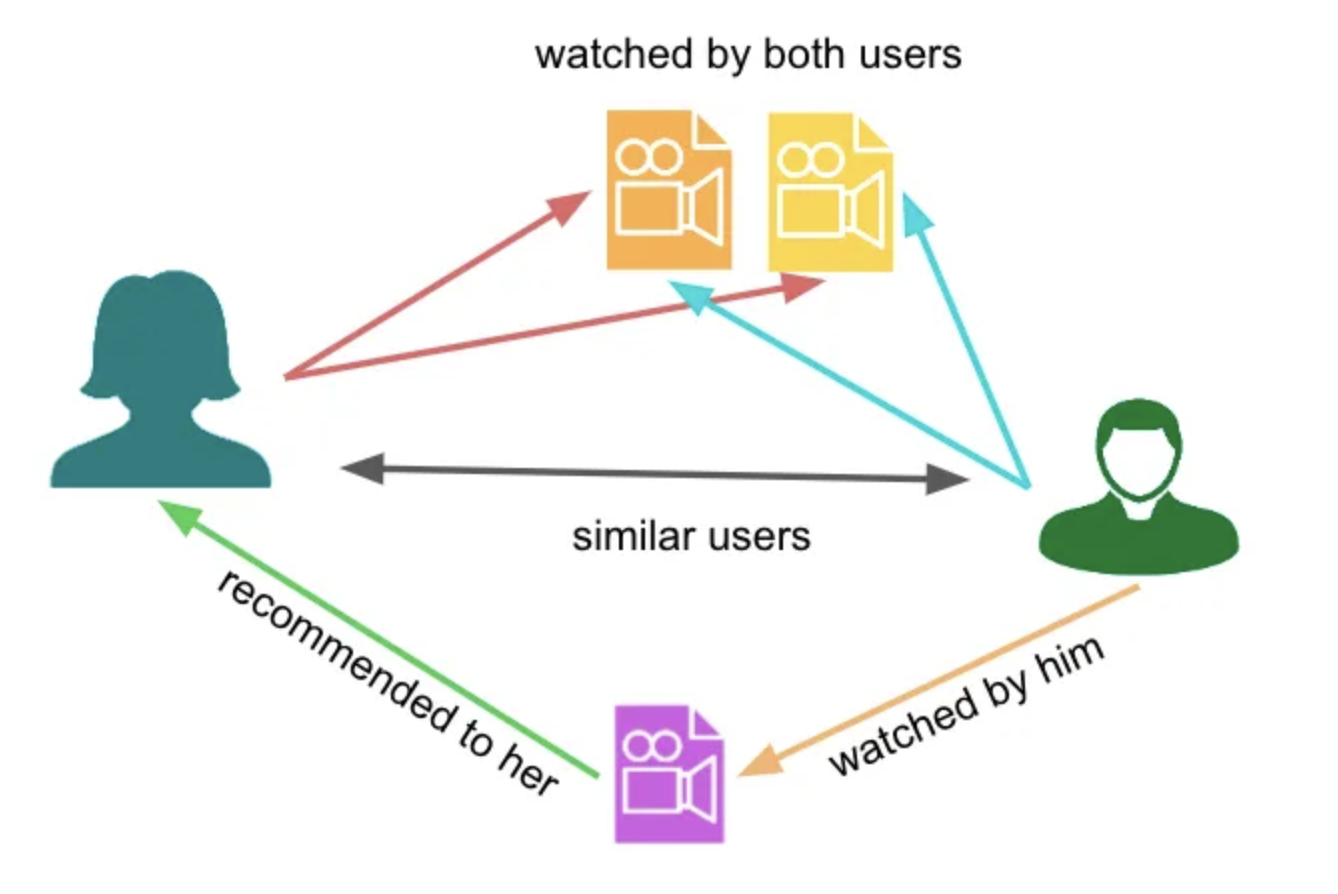

Image source - Medium

<h3> <span style="color:green;">How to implement Collaborative Filtering?</span></h3>
<h4><b><span style="color:brown;">Steps:-</span></b></h4>
<ol>
    <li><b>Combine Features:-</b></li>We have 6 features. We will combine these features into a single text column called 'combined_features' and work with it.
    <li><b>Vectorizations:-</b></li>To understand the characteristics of the movie features, we need to convert all the text into vectors to represent movies in a common vector space. TF-IDF vectorization is well-suited for such scenarios. TF-IDF typically creates a sparse, high-dimensional feature space, where each word in the corpus becomes a feature. It is particularly effective for tasks like document similarity and aids in capturing the uniqueness of movie descriptions. Therefore, we will employ TF-IDF vectorization to convert the text data into numerical vectors.
    <li><b>Similarity Measure:-</b></li> There are several similarity measures available, including cosine similarity, Pearson correlation coefficient, Jaccard similarity, and Euclidean distance, among others. In content-based recommendation systems and for high-dimensional data, cosine similarity proves to be particularly useful. (Note: For collaborative recommendation systems, Pearson similarity often performs better than cosine similarity.) Therefore, we will utilize cosine similarity to compute similarity scores between movies, using the linear kernel.
    <li><b>Recommdation Function:-</b></li>We will define a function recommend_movies() to recommend similar movies based on the similarity scores.
</ol>

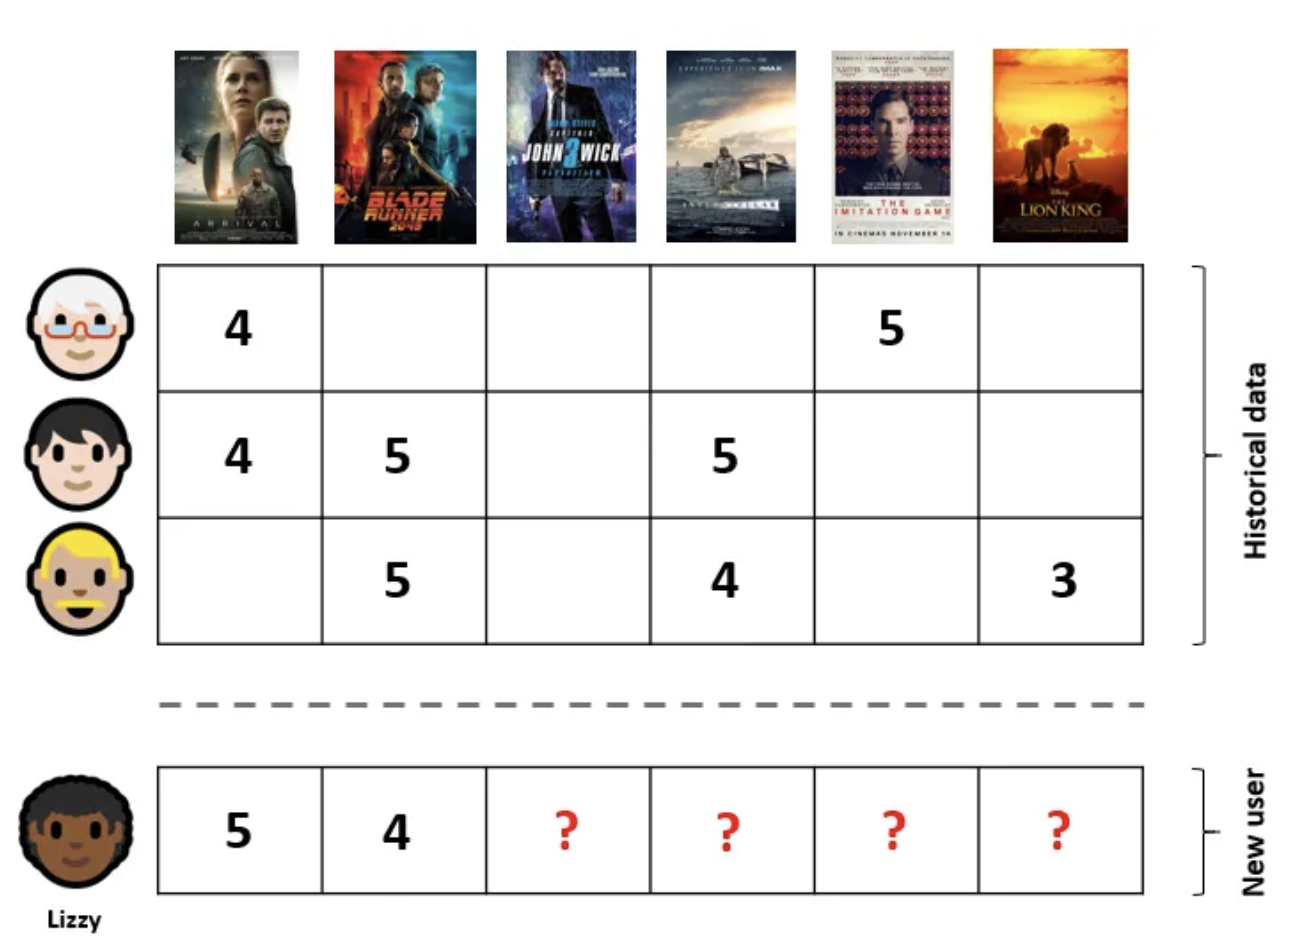

Image source - Medium

<h1> <span style="color:red;"> Step 1:- Prepare Data</span></h1>

In [1]:
import ssl
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from fastai.collab import *
from fastai.tabular.all import *

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
path = untar_data(URLs.ML_100k)

Lets convert all the required data into proper format. While downloading we got many files but we only need 3 of them .Basic infos of those 3 files,

<ol>
    <li><b>u.item-></b></li> Information about the items (movies); this is a tab separated list of,
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.
    <li><b>u.user-></b></li> Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.
    <li><b>u.data-></b></li> The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are numbered consecutively from 1.  The data is randomly ordered. This is a tab separated list of,<br> 
	         user id | item id | rating | timestamp <br> 
             The time stamps are unix seconds since 1/1/1970 UTC
</ol>

In [3]:
movie_columns = ['movie_id','movie_title','release_date','video_release_date','url','unknown','action',\
                 'adventure','animation','for_kids','comedy','crime','documentary','drama','fantasy',\
                 'film_noir','horror','musical','mystery','romance','sci_fi','thriller','war','western']
user_columns = ['user_id','age','gender','occupation','zip_code']
user_rating_columns = ['user_id','movie_id','rating','timestamp']

In [4]:
movies_df = pd.read_csv(path/'u.item', delimiter='|', header=None, names=movie_columns, encoding = 'latin-1')
users_df = pd.read_csv(path/'u.user', delimiter='|', header=None, names=user_columns)
user_ratings_df = pd.read_csv(path/'u.data', delimiter='\t', header=None,names=user_rating_columns)

In [5]:
movies_df.shape[0],users_df.shape[0],user_ratings_df.shape[0]

(1682, 943, 100000)

In [6]:
movies_df.head(2)
# as we can see not all columns are important so we can drop release_date, video_release_date, url columns

,movie_id,movie_title,release_date,video_release_date,url,unknown,action,adventure,animation,for_kids,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
users_df.head(2)

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [8]:
user_ratings_df.head(2) # we can drop timestamp column

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


Merge the dataframes to create a single user-item dataframe

In [9]:
merged_user_df = pd.merge(users_df,user_ratings_df,how='inner',on='user_id')

In [10]:
merged_df=pd.merge(merged_user_df,movies_df,how='inner',on='movie_id')

In [11]:
merged_df[merged_df['user_id']==1].sort_values(by='movie_id').head(5)

,user_id,age,gender,occupation,zip_code,movie_id,rating,timestamp,movie_title,release_date,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
26054,1,24,M,technician,85711,1,5,874965758,Toy Story (1995),01-Jan-1995,...,0,0,0,0,0,0,0,0,0,0
22985,1,24,M,technician,85711,2,3,876893171,GoldenEye (1995),01-Jan-1995,...,0,0,0,0,0,0,0,1,0,0
39333,1,24,M,technician,85711,3,4,878542960,Four Rooms (1995),01-Jan-1995,...,0,0,0,0,0,0,0,1,0,0
35836,1,24,M,technician,85711,4,3,876893119,Get Shorty (1995),01-Jan-1995,...,0,0,0,0,0,0,0,0,0,0
31702,1,24,M,technician,85711,5,3,889751712,Copycat (1995),01-Jan-1995,...,0,0,0,0,0,0,0,1,0,0


In [12]:
merged_df.shape[0]

100000

In [13]:
merged_df.columns

Index(['user_id', 'age', 'gender', 'occupation', 'zip_code', 'movie_id',
       'rating', 'timestamp', 'movie_title', 'release_date',
       'video_release_date', 'url', 'unknown', 'action', 'adventure',
       'animation', 'for_kids', 'comedy', 'crime', 'documentary', 'drama',
       'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance',
       'sci_fi', 'thriller', 'war', 'western'],
      dtype='object')

<h1> <span style="color:red;"> Step 2:- EDA</span></h1>

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;1. Basic Preprocessing </span></h2> 

In [14]:
merged_df.drop_duplicates(inplace=True)

<h2> <span style="color:blue;">&nbsp;&nbsp;&nbsp;2. Feature Engineering </span></h2> 

In [15]:
sparsed_columns=['unknown', 'action', 'adventure', 'animation','for_kids', 'comedy', \
                 'crime', 'documentary', 'drama', 'fantasy','film_noir', 'horror', 'musical',\
                 'mystery', 'romance', 'sci_fi','thriller', 'war', 'western']

merged_df['genre'] = merged_df[sparsed_columns].apply(lambda x: ','.join([col for col,\
                                                                          val in x.items() if val == 1]), axis=1)

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Drop Unnecessary Columns</span></h3> 

In [16]:
dropped_feature=['timestamp', 'release_date', 'video_release_date', 'url']
merged_df.drop(columns=dropped_feature,inplace=True)
merged_df.drop(columns=sparsed_columns,inplace=True)

To build a collaborative recommender system, we need to determine which features are relevant for modeling user preferences and item recommendations. Here's a breakdown of the features you've listed and their relevance:
<ol>
<li><b>user_id:</b></li> Essential for identifying unique users in the system. This is a crucial feature for collaborative filtering as it helps in understanding user behavior and preferences.
<li><b>age:</b></li> Age could potentially provide insights into user preferences based on age groups. It might help in segmenting users for personalized recommendations. However, it's not always a definitive predictor of movie preferences.
<li><b>gender:</b></li> Gender can also be a useful feature for segmentation and personalization. It might help in recommending movies that are popular among specific genders or for providing gender-specific recommendations. However, it's not the only determinant of movie preferences.
<li><b>occupation:</b></li> Occupation can offer insights into users' lifestyles and interests, which could influence movie preferences. Certain occupations might correlate with specific movie genres or types of content consumption.
<li><b>zip_code:</b></li> Zip code might provide geographic information, which can be useful for localizing recommendations or understanding regional preferences. However, its utility might be limited compared to other features.
<li><b>movie_id:</b></li> Essential for identifying unique movies in the system. This is a fundamental feature for collaborative filtering, as it helps in understanding item characteristics and user-item interactions.
<li><b>rating:</b></li> The rating provided by users for a movie is a crucial feature for collaborative filtering. It represents user preferences and interactions with movies in the system.
<li><b>movie_title:</b></li> While the movie title itself might not directly contribute to the recommendation process, it could be used for display purposes or for providing additional context to users.
<li><b>genre:</b></li> The genre of a movie is highly relevant for recommendations. It helps in understanding the content and characteristics of movies, and it's essential for content-based filtering and hybrid recommendation approaches.
</ol>
In summary, the user-related features (user_id, age, gender, occupation, zip_code) and movie-related features (movie_id, genre) are particularly relevant for building a collaborative recommender system. The rating feature is crucial as it represents user-item interactions, which form the basis of collaborative filtering algorithms. The movie title might not directly contribute to recommendations but could be used for user interface purposes. Ensure you preprocess and engineer these features appropriately before feeding them into your recommendation model.

<h3> <span style="color:green;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Understand the dataset</span></h3> 

In [17]:
merged_df[merged_df['user_id']==1].head(3)

,user_id,age,gender,occupation,zip_code,movie_id,rating,movie_title,genre
0,1,24,M,technician,85711,61,4,Three Colors: White (1994),drama
59,1,24,M,technician,85711,189,3,"Grand Day Out, A (1992)","animation,comedy"
125,1,24,M,technician,85711,33,4,Desperado (1995),"action,romance,thriller"


In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      100000 non-null  int64 
 1   age          100000 non-null  int64 
 2   gender       100000 non-null  object
 3   occupation   100000 non-null  object
 4   zip_code     100000 non-null  object
 5   movie_id     100000 non-null  int64 
 6   rating       100000 non-null  int64 
 7   movie_title  100000 non-null  object
 8   genre        100000 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


In [19]:
merged_df.describe(include='all')

,user_id,age,gender,occupation,zip_code,movie_id,rating,movie_title,genre
count,100000.00000,100000.000000,100000,100000,100000,100000.000000,100000.000000,100000,100000
unique,NaN,NaN,2,21,795,NaN,NaN,1664,216
top,NaN,NaN,M,student,55414,NaN,NaN,Star Wars (1977),drama
freq,NaN,NaN,74260,21957,1103,NaN,NaN,583,13257
mean,462.48475,32.969850,NaN,NaN,NaN,425.530130,3.529860,NaN,NaN
std,266.61442,11.562623,NaN,NaN,NaN,330.798356,1.125674,NaN,NaN
min,1.00000,7.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN
25%,254.00000,24.000000,NaN,NaN,NaN,175.000000,3.000000,NaN,NaN
50%,447.00000,30.000000,NaN,NaN,NaN,322.000000,4.000000,NaN,NaN
75%,682.00000,40.000000,NaN,NaN,NaN,631.000000,4.000000,NaN,NaN


In [20]:
merged_df.isnull().sum() #Check for missing values

user_id        0
age            0
gender         0
occupation     0
zip_code       0
movie_id       0
rating         0
movie_title    0
genre          0
dtype: int64

Check for outliers by visualizing the distribution of numerical columns

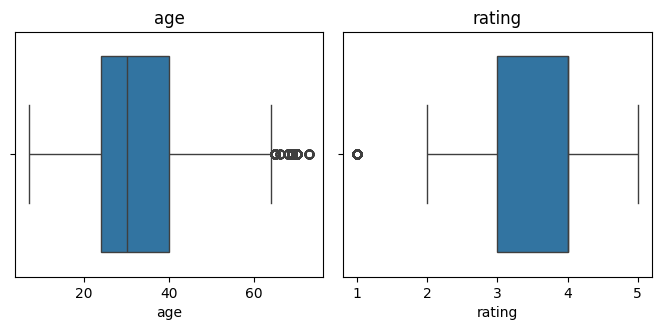

In [21]:
numerical_columns=merged_df.select_dtypes(include=['int64','float64']).columns
i_counter=1

plt.figure(figsize=(10,6))
for i, col in enumerate(numerical_columns,1):
    if '_id' not in col:
        plt.subplot(2,3,i_counter)
        sns.boxplot(x=merged_df[col])
        plt.title(col)
        i_counter=i_counter+1
plt.tight_layout()
plt.show()    
    

We can see very few people abive age of 60 gave movie rating and also generally people gave rating between 2 to 5, 1 rating is very rare occurrence. Lets see their relationship with each other.

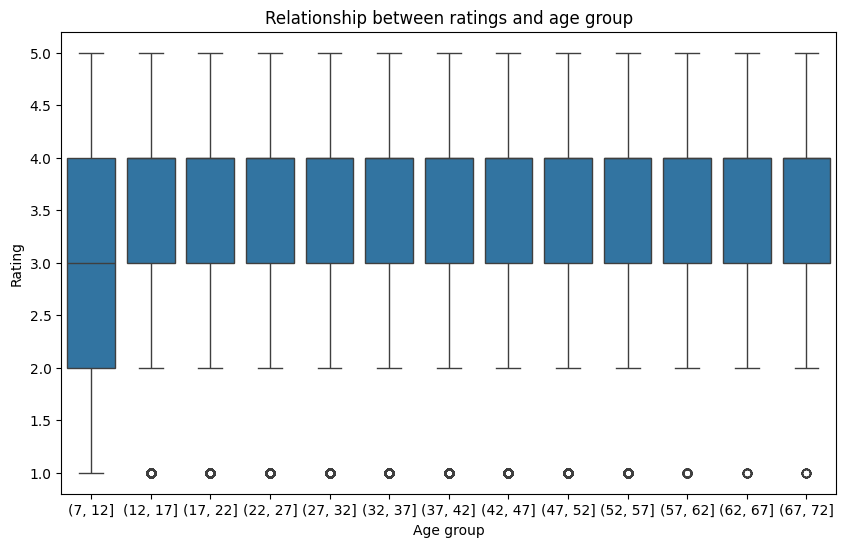

In [22]:
merged_df['age_group']=pd.cut(merged_df['age'], range(7, 75, 5))
plt.figure(figsize=(10,6))
sns.boxplot(x='age_group', y='rating', data=merged_df)
plt.title('Relationship between ratings and age group')
plt.xlabel('Age group')
plt.ylabel('Rating')
plt.show()

Seems like the outlier only present for age 12-72, also the mean rating is different for this group. we need to check the relationship between rating-gender and rating-occupation just to check if those factora impact the rating. but before doing that lets check the distribution of age column.

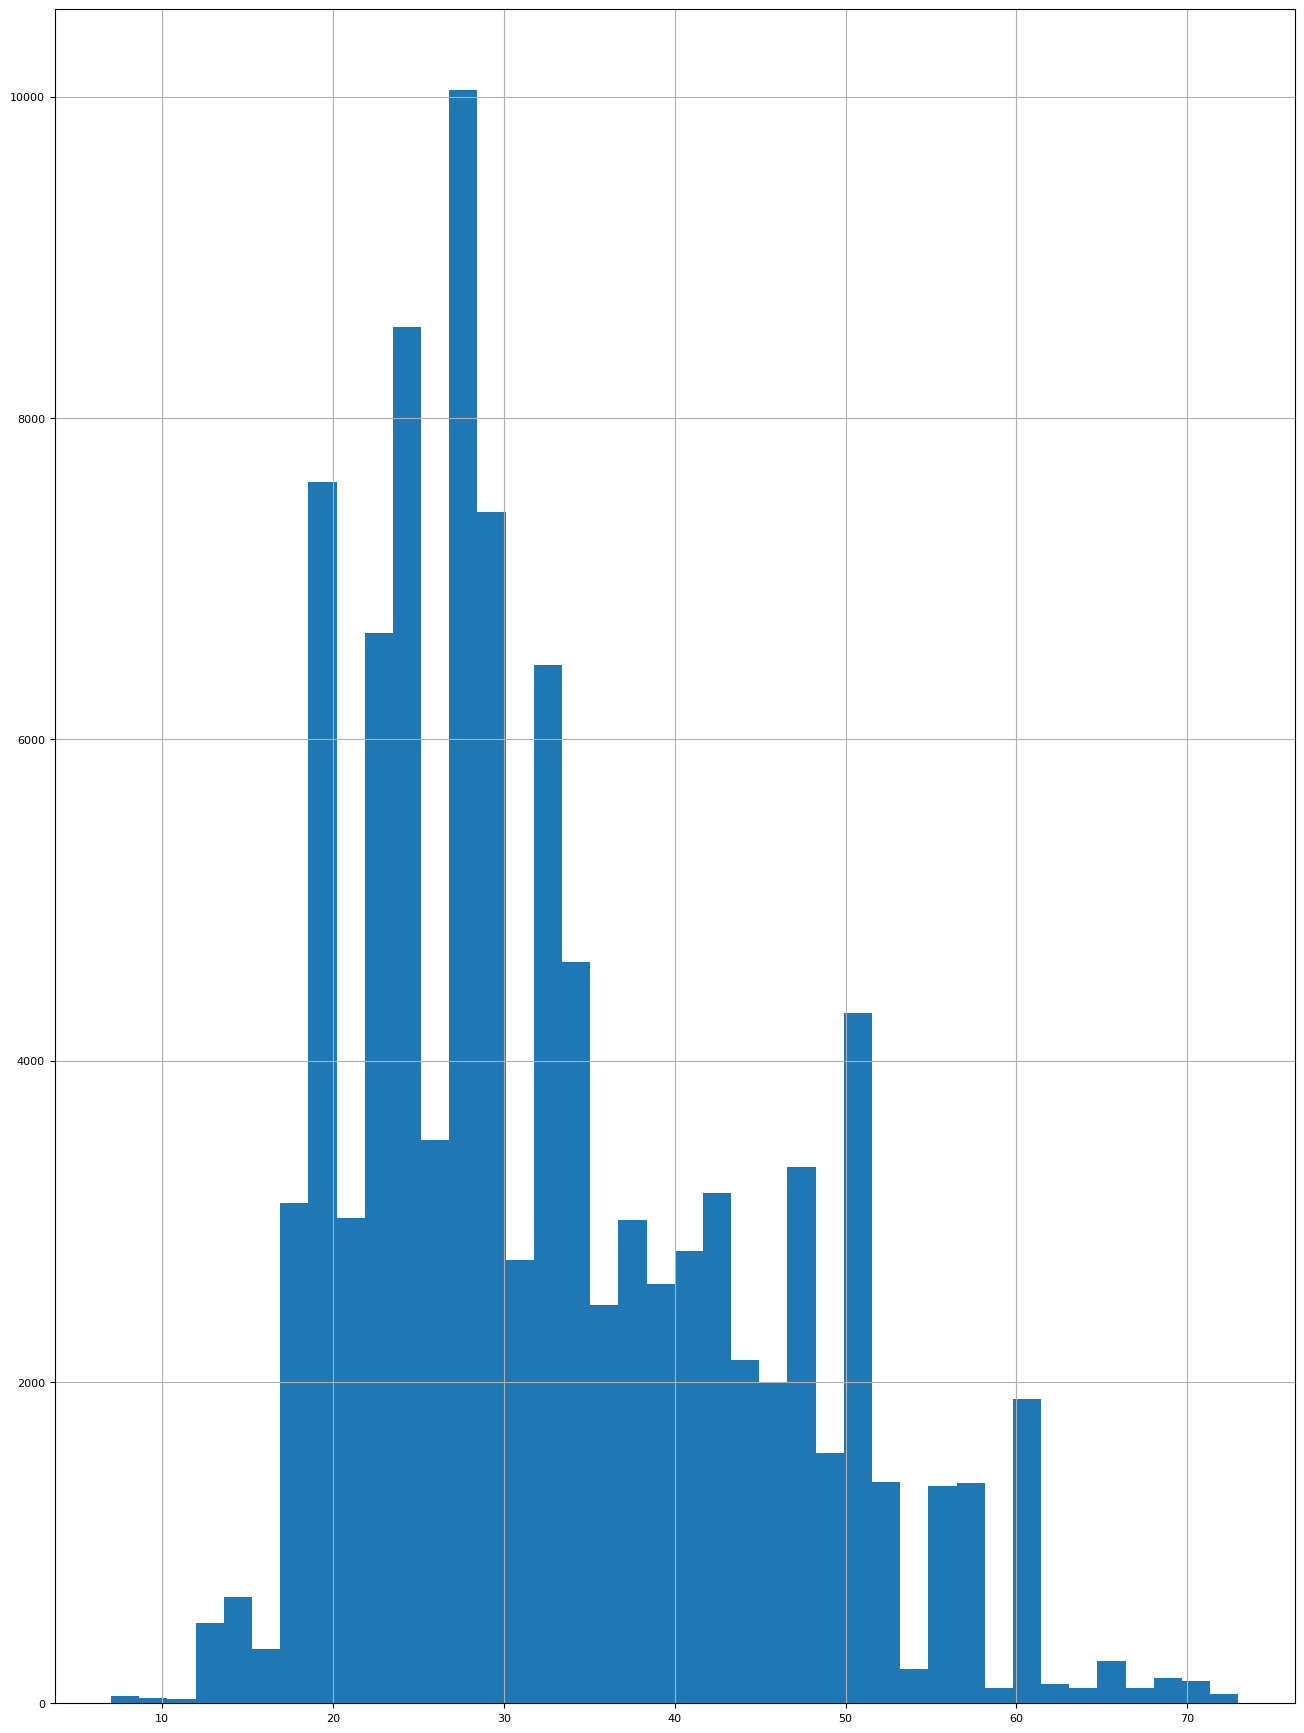

In [23]:
plt.figure(figsize=(10,6))
merged_df['age'].hist(figsize=(16,22),bins=40,xlabelsize=8, ylabelsize=8);

We can see the most voted groups are in around 18-35 age range. So the votes given by age range 7-12 won't impact much of our analysis. Lets see how rating is getting impacted with gender and occupation.

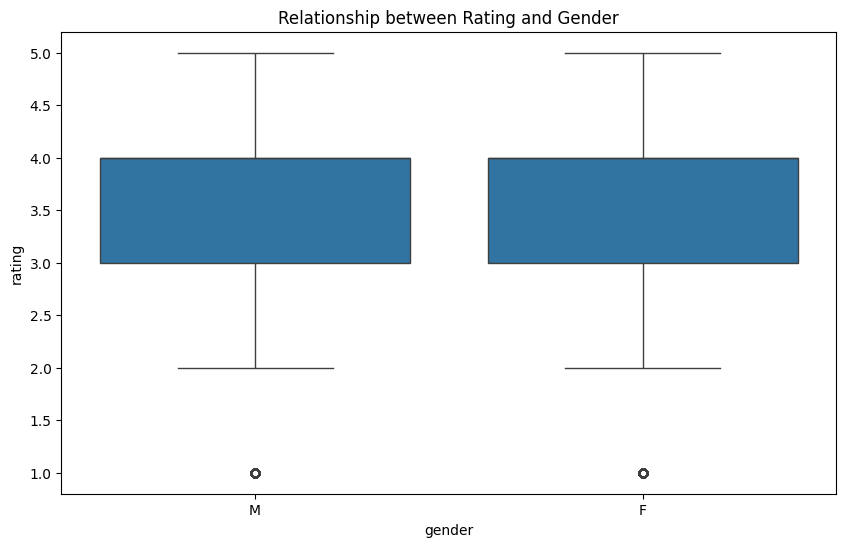

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x='gender',y='rating',data=merged_df)
plt.xlabel("gender")
plt.ylabel("rating")
plt.title("Relationship between Rating and Gender")
plt.show()

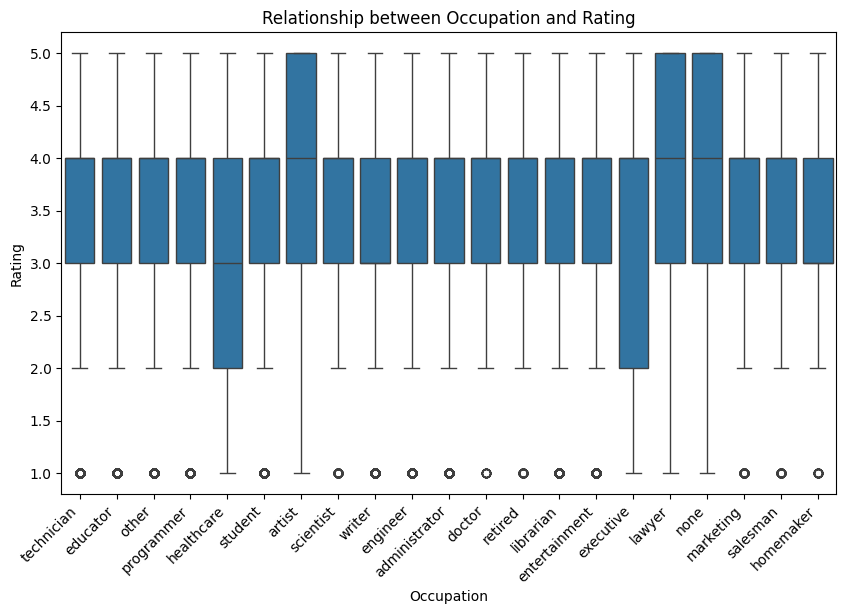

In [25]:
plt.figure(figsize=(10,6))
sns.boxplot(x='occupation',y='rating',data=merged_df)
plt.xlabel("Occupation")
plt.ylabel("Rating")
plt.title("Relationship between Occupation and Rating")
plt.xticks(rotation=45,ha='right')
plt.show()

We can see on an average "artists","lawyers" and "none" occupation tends to give more rating than average where those who are in  "healthcare" and "executive" profession tends to give lesser rating than others. Also only for these 5 groups no outliers present, their rating can anything between 1 to 5 (1,1 .5, 2..5)

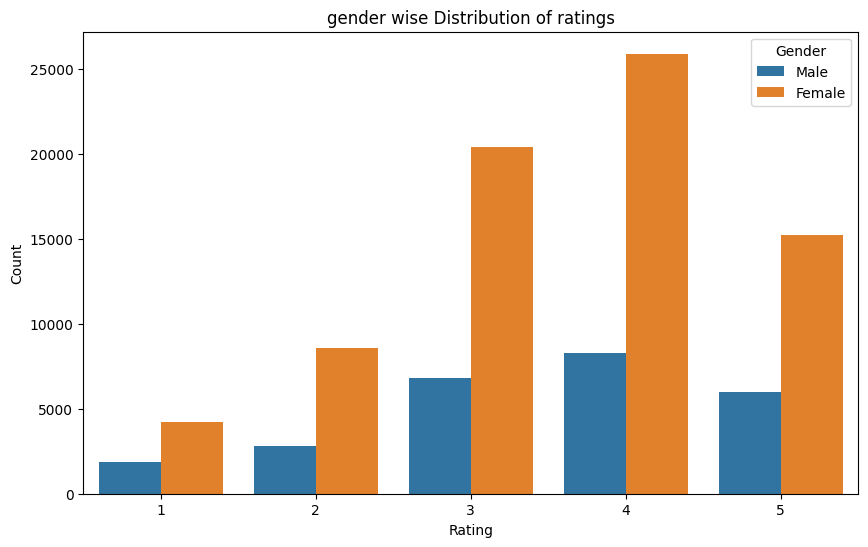

In [29]:
gender_labels= {"F" : "Female", "M": "Male"}
plt.figure(figsize=(10,6))
sns.countplot(x='rating',hue='gender',data=merged_df)
plt.title("gender wise Distribution of ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.legend(title="Gender", labels=[gender_labels.get(g,g) for g in ['M','F']])
plt.show()